In [1]:
print(("Let's get this money!!"))

Let's get this money!!


In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# !cp /content/gdrive/MyDrive/HW5_train_val.zip /content
# !unzip HW5_train_val.zip

In [3]:
# !mkdir /content/valid_HR
# !mkdir /content/train_HR

# !mv DIV2K_train_HR.zip /content/train_HR  
# !mv DIV2K_valid_HR.zip /content/valid_HR

# !unzip /content/train_HR/DIV2K_train_HR.zip
# !unzip /content/DIV2K_train_LR_bicubic_X4.zip
# !unzip /content/valid_HR/DIV2K_valid_HR.zip
# !unzip /content/DIV2K_valid_LR_bicubic_X4.zip


In [1]:
import numpy as np
import torch
import torchvision   
import torch.nn as nn
from torchvision import transforms

import torch.nn.functional as F
import torch.utils.data as data
from PIL import Image
from torch.utils.data import Dataset, DataLoader
cuda = torch.device('cuda')
cpu = torch.device('cpu')
device = cuda

BATCH_SIZE = 16

In [2]:
content_path = '/home/ubuntu/content/'

In [3]:
## To build SRGAN, let's start with a residual block.
## This is adapted from HW2, itself adapted from instructor-provided code

class SimpleResidualBlock(nn.Module):
    def __init__(self, in_channel, main_channel, stride=1, step=False):
        super().__init__()

        self.in_channel = in_channel
        self.main_channel = main_channel
        self.step = step
        channel_size = main_channel
        self.conv1 = nn.Conv2d(in_channel, channel_size, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv2 = nn.Conv2d(channel_size, channel_size, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(channel_size)
        self.bn2 = nn.BatchNorm2d(channel_size)

        nn.init.kaiming_normal_(self.conv1.weight)
        nn.init.kaiming_normal_(self.conv2.weight)

        if stride == 1 and (in_channel == main_channel):
            self.shortcut = nn.Identity()
        else:
            self.shortcut = nn.Sequential(nn.Conv2d(in_channel, channel_size, kernel_size=1, stride=stride, padding=0, bias=False),
                                          nn.BatchNorm2d(channel_size))
        self.prelu_1 = torch.nn.PReLU()
        self.prelu_2 = torch.nn.PReLU()
    
    def forward(self, x):

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.prelu_1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        shortcut = self.shortcut(x)
        out = self.prelu_2(out + shortcut)
        return out

In [4]:
## Block near the end which there's two of

class ShufflerBlock(nn.Module):
    def __init__(self, in_channel):
        super().__init__()
        self.conv_0 = nn.Conv2d(in_channels=in_channel, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.pixel_shuffler_1 = torch.nn.PixelShuffle(2)
        nn.init.kaiming_normal_(self.conv_0.weight)
        self.act = torch.nn.PReLU()

    def forward(self, x):
        out = x
        out = self.conv_0(out)
        out = self.pixel_shuffler_1(out)
        out = self.act(out)

        return out


In [5]:
## Building the generator network.
## The network architecture is given in the paper. there is notation "k_n_s_",
## where k refers to kernel, n is number of feature maps, s is stride.

## to be 100% explicit: this idea is from the SRGAN paper!!
class SRGAN_Generator(nn.Module):
    def __init__(self):
        super(SRGAN_Generator, self).__init__()
        
        # I believe our images are three-channel...
        in_channel = 3 
        
        # initial convolution
        self.conv_0  = nn.Conv2d(in_channel, out_channels=64, kernel_size=9, stride=1, padding=4)

        # residual blocks -- six of 'em
        self.resid_1 = SimpleResidualBlock(in_channel=64, main_channel=64)
        self.resid_2 = SimpleResidualBlock(in_channel=64, main_channel=64)
        self.resid_3 = SimpleResidualBlock(in_channel=64, main_channel=64)
        self.resid_4 = SimpleResidualBlock(in_channel=64, main_channel=64)
        self.resid_5 = SimpleResidualBlock(in_channel=64, main_channel=64)
        self.resid_6 = SimpleResidualBlock(in_channel=64, main_channel=64)

        # convolution to which we add the initial image
        self.conv_7 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn_8 = nn.BatchNorm2d(64)

        # shuffler blocks near the end
        self.shuffler_9 = ShufflerBlock(64)
        self.shuffler_10 = ShufflerBlock(64)

        # final convolution
        self.conv_11 = nn.Conv2d(in_channels=64, out_channels=3, kernel_size=9, stride=1, padding=4)

    def forward(self, x):
        out = x

        out = self.conv_0(out)

        out = self.resid_1(out)
        out = self.resid_2(out)
        out = self.resid_3(out)
        out = self.resid_4(out)
        out = self.resid_5(out)
        out = self.resid_6(out)

        out = self.conv_7(out)
        out = self.bn_8(out)

        out = self.shuffler_9(out)
        out = self.shuffler_10(out)

        out = self.conv_11(out)
        return out

In [6]:
## Now to create a discriminator
## Again I am following the SRGAN paper

## I'm starting with the repeated block from the paper.

class DBlock(nn.Module):
    def __init__(self, in_, n, k, s):
        super(DBlock, self).__init__()
        self.layers = nn.Sequential(

        nn.Conv2d(in_channels=in_, out_channels=n, kernel_size=k, stride=s, padding=1),
        nn.BatchNorm2d(n),
        nn.LeakyReLU()
        )

    def forward(self, x):
        return self.layers.forward(x)


In [7]:
## Creating the network

class SRGAN_Discriminator(nn.Module):
    def __init__(self):
        super(SRGAN_Discriminator, self).__init__()

        self.layers = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, stride=1),
        nn.LeakyReLU(),
        DBlock(64, 64, 3, 2),

        DBlock(64, 128, 3, 1),
        DBlock(128, 128, 3, 2),

        DBlock(128, 256, 3, 1),
        DBlock(256, 256, 3, 2),

        DBlock(256, 512, 3, 1),
        DBlock(512, 512, 3, 2),

        nn.AdaptiveAvgPool2d(1),

        nn.Conv2d(512, 1024, kernel_size=1),
        nn.LeakyReLU(),
        nn.Conv2d(1024, 1, kernel_size=1),
        nn.Sigmoid())

    def forward(self, x):
    
        return self.layers.forward(x)

In [8]:
## Creating a dataset/dataloader class
## Some code modified from recitation.
vgg = torchvision.models.vgg19(pretrained=True)

# This snippet was taken from https://www.programcreek.com/python/example/108006/torchvision.models.vgg19
vgg = nn.Sequential(*list(vgg.features.children())[:36])
vgg.to(device)


T = torchvision.transforms
# to_tensor = T.ToTensor()
Dataset = data.Dataset
DataLoader = data.DataLoader
nn = torch.nn
optim = torch.optim


In [9]:
# datasets = torchvision.datasets.ImageFolder(root='/home/ubuntu/content/DIV2K_valid_LR_bicubic')
# train_dataset_LR = torchvision.datasets.ImageFolder(root='/home/ubuntu/content/DIV2K_train_LR_bicubic')
# dev_dataset_HR = torchvision.datasets.ImageFolder(root='/home/ubuntu/content/DIV2K_valid_HR/')
# train_dataset_HR = torchvision.datasets.ImageFolder(root='/home/ubuntu/content/DIV2K_train_HR/')

In [10]:
vgg.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [11]:
#transform below from:
#https://jbencook.com/pytorch-normalize/

# Comment from Shentong:
# We need to do transformation for VGG to extract the useful features.

# I am transforming the images, and I also am trying out a function that should
# transform them back to "normal".
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])


# Here is the function to transform a normalized tensor into
# a tensor with the original mean and standard deviation.

def undo_transform(img_tensor):
    # Apply to individual images.
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    for i in range(img_tensor.shape[0]):
        img_tensor[i, :, :] = img_tensor[i, :, :] * std[i] + mean[i]
    return img_tensor

In [12]:
# Comment from Shentong:
# The patch method seems appropriate.

def patch_lr_hr(lr, hr):
    c, H, W = lr.shape
    c1, c2 = np.random.randint(0, H - PATCH_SIZE - 1), np.random.randint(0, W - PATCH_SIZE - 1)
    d1, d2 = 4 * c1, 4 * c2

    lr = lr[:, c1:(c1 + PATCH_SIZE), c2:(c2 + PATCH_SIZE)]
    hr = hr[:, d1:(d1 + 4 * PATCH_SIZE), d2:(d2 + 4 * PATCH_SIZE)]

    return lr, hr


In [13]:
class MyDataset(data.Dataset): ## for Generator data
    def __init__(self, LR, HR):
        self.LR_images = LR # img datafolders
        self.HR_images = HR # img datafolder

    def __len__(self):
        return len(self.LR_images)

    def __getitem__(self, index):
        LR = self.LR_images[index][0]
        HR = self.HR_images[index][0]
        return patch_lr_hr(LR, HR)

transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])


In [14]:
# have to move all files from folder level to subfolder level... ?!?!?!?

In [15]:
PATCH_SIZE = 32
train_folder_LR = torchvision.datasets.ImageFolder(root=content_path+'DIV2K_train_LR_bicubic', 
                                                   transform=transform_train)

train_folder_HR = torchvision.datasets.ImageFolder(root=content_path+'DIV2K_train_HR', 
                                                   transform=transform_train)

valid_folder_LR = torchvision.datasets.ImageFolder(root=content_path+'DIV2K_valid_LR_bicubic', 
                                                   transform=transform_test)

valid_folder_HR = torchvision.datasets.ImageFolder(root=content_path+'DIV2K_valid_HR', 
                                                   transform=transform_test)


In [16]:
full_train_data = MyDataset(train_folder_LR, train_folder_HR)
full_valid_data = MyDataset(valid_folder_LR, valid_folder_HR)

train_loader = DataLoader(full_train_data, batch_size=BATCH_SIZE)
test_loader = DataLoader(full_valid_data, batch_size=BATCH_SIZE)

In [17]:
# Training functions for the GAN
# These were inspired by the code that was given in
# the Fall 2020 GAN recitation.

def discriminator_train(x_real, x_fake, loss_function):
    # Never forget to zero the grad!
    Discriminator.zero_grad()
    bs = x_real.shape[0]
#     av_l1 = 0

    # Pull in the real data, calculate the loss on it.
    y_real = torch.ones(bs).float()
    x_real = x_real.to(cuda)
    y_real = y_real.to(cuda)

    real_scores = Discriminator(x_real).reshape(-1)
    discriminator_real_loss = loss_function(real_scores, y_real)
    av_l1 = torch.abs(real_scores-y_real).mean().item()
    

    # Pull in some fake data, calculate the loss on it.
    y_fake = torch.zeros(bs).float()
    x_fake = x_fake.to(cuda)
    y_fake = y_fake.to(cuda)

    fake_scores = Discriminator(x_fake).reshape(-1)
    discriminator_fake_loss = loss_function(fake_scores, y_fake)
    av_l1 += torch.abs(fake_scores-y_fake).mean().item()
    
    # Backprop/Update
    loss = discriminator_real_loss + discriminator_fake_loss
    loss.backward()
    D_optimizer.step()
    
    return loss.item(), av_l1/2 # divide by 2 to get the mean (this is just for understanding purposes)


def generator_train(lr, hr, loss_function):
    # Never forget to zero the grad!
    Generator.zero_grad()
    Discriminator.eval()

    lr = lr.to(cuda)
    lr = Generator(lr)
    hr = hr.to(cuda)

    y = Discriminator(lr).to(cuda)
    generator_loss = loss_function(vgg.forward(lr), vgg.forward(hr), y)

    generator_loss.backward()
    G_optimizer.step()
    
    return generator_loss.item()


# is vgg_forward to compute the VGG_5,4 feature map? 

In [18]:
disc_loss = nn.BCELoss()
Generator = SRGAN_Generator()
Discriminator = SRGAN_Discriminator()
l1 = torch.nn.L1Loss()
# l1_2 = torch.nn.L1Loss()

def gen_loss(lr, hr, disc_output):
    # Weight is a hyperparameter
    # Try other weights. Try powers of 10... 1e-2, 1e-4...
    
    # here the version for low gradients is implemented, i.e. when discriminator
    # easily discriminates, the disc_output loss is low, so instead of minimizing log(1-disc_out) we
    # maximize log(disc_out) which is way bigger
    
    # But we should experiment when to include back the minimization and change or not the weight.
    
    content = l1(lr, hr)
    
    adversarial1 = torch.log(1-disc_output).mean()
    adversarial2 = -torch.log(disc_output).mean()
    
#     adversarial = -torch.log(disc_output).mean() # changed the loss to try with the other one, and it worked well
# for 10 epochs but then the loss were really low


    return content + WEIGHT_ADVERS * (adversarial1+adversarial2)

In [19]:
WEIGHT_ADVERS = 0.001
# try with 1e-4 now because the adversarial is way too big i guess, to verify though! 

In [20]:
lr = 0.0001
G_optimizer = optim.Adam(Generator.parameters(), lr=lr)
D_optimizer = optim.Adam(Discriminator.parameters(), lr=lr)

In [47]:
G_scheduler = torch.optim.lr_scheduler.StepLR(G_optimizer, gamma=0.5, step_size=1)
D_scheduler = torch.optim.lr_scheduler.StepLR(D_optimizer, gamma=0.8, step_size=5)

0.2081788033246994
0.20653367787599564
0.1990040789047877
0.20110854879021645
0.2056618183851242
0.20312278221050897
0.20261962498937333
0.19993583299219608
0.19467279811700186
0.1968538299202919
0.1954483606598594
0.1962988202770551
0.1956821267421429
0.19528260401317052
0.19694834450880686
0.19815360102802515
0.1978545408038532
0.1970657077100542
0.19812809009301036
0.19716265872120858
0.198980022753988
0.1996106200597503
0.1993437286304391
0.20199698023498058
0.2023167759180069
0.20319338429432648
0.2021962277315281
0.20234964787960052
0.20125381031940723
0.20167206426461537
0.20243619142040128
0.2022065664641559
0.20376415911949042
0.20307786499752717
0.2033814596278327
0.20494501582450336
0.20521635743411812
0.20521086336750732
0.2054332666672193
0.20643784813582897
0.2068575060949093
0.20690003356763295
0.2074596795231797
0.20746024867350404
0.20802233980761634
0.20818285546872928
0.20737682060992463
0.20748263907929262
0.20715155406874053
0.20706031799316407
epoch is done:  0


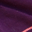

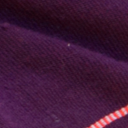

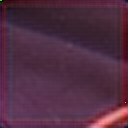

0.20708020469721625
0.20705683472064826
0.20712589233551384
0.20805231205843114
0.2079787723042748
0.20711322128772736
0.20663894111650033
0.20637168966490646
0.20575314330852637
0.2056067739923795
0.2052747717157739
0.20518207165502733
0.20484138552158598
0.20549006084911525
0.20498831340899834
0.20460936494848944
0.20414116889683168
0.2042878327124259
0.20409900554712268
0.20450510382652282
0.2042415393909938
0.20433425385918882
0.20414001627327644
0.20429508851186648
0.20365921477476756
0.20350588132676325
0.2033389253275735
0.20343277546075675
0.20389512200144272
0.2037250731140375
0.20355114175213707
0.20395368919139956
0.2042154107826302
0.20408786602673076
0.20400742590427398
0.20408914411483808
0.20443169961030455
0.20431419445032423
0.20423311715045672
0.20441176990667978
0.20410957719598496
0.2040685868781546
0.2038267684239213
0.20372599585259216
0.2037352061585376
0.20342174110313258
0.2033658511552614
0.20329508048539258
0.20290058836190386
0.20277432307600976
epoch is don

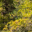

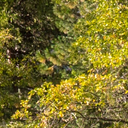

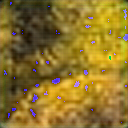

0.20282004758863165
0.20261874619652243
0.20256674897323534
0.202205253048585
0.2019924459003267
0.20156855122098383
0.2016750122899207
0.2011807952766065
0.201205315939877
0.20173097171566703
0.20169928857872077
0.20172219816595316
0.2015293202305262
0.20171912119053959
0.20130695415579755
0.20116065442562103
0.20115603774021834
0.20112210613186077
0.2010258794331751
0.20127498221894105
0.20138639371749784
0.20164123629448844
0.20174820357706488
0.2019189485619145
0.20194653916358948
0.20219949810277849
0.20190990510887988
0.2016436877893284
0.20161505759686463
0.2014147719511619
0.20129892855655146
0.20147939963322697
0.2014314153588804
0.20146442304796247
0.2013002938694424
0.20152733420186184
0.20151836658916333
0.20163745789424234
0.20184349081070302
0.20249743046505111
0.20256768991338445
0.20231590147169543
0.20260294208993446
0.2026093929178185
0.20238171517848969
0.20202534441670325
0.2017100720989461
0.20182487207490044
0.2017037819495937
0.20160512755314508
epoch is done:  2

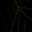

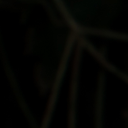

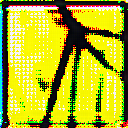

0.20157365076589268
0.2016082680539081
0.20139978952657164
0.20126734035355703
0.20103825628757477
0.20079738264664626
0.20053233367622278
0.20044130350970016
0.2006069318678394
0.2006252659484744
0.20052586514387072
0.20073577982408028
0.20045383265413388
0.2005379706984613
0.20054003578243834
0.20068015427474517
0.20055442816483046
0.20060013110438982
0.20074571069528366
0.2008191169184797
0.20064802781531685
0.20068141306902088
0.20054958019987007
0.20064848353122844
0.2007343693290438
0.2007090153003281
0.20083634799483133
0.20087226990903362
0.20070991985624728
0.20065564753280746
0.20059534899108317
0.20045083040719505
0.20053878206698622
0.20049509106446867
0.200516620922733
0.20075087585756857
0.20072813172710133
0.20061264527921982
0.20069462604938992
0.20103571799240613
0.20097323581186263
0.2008633432754626
0.20099404454231262
0.20086186916865023
0.20082994997501374
0.20092879623478774
0.20104769212642903
0.20109696091726573
0.201052889901789
0.20121453702449799
epoch is don

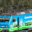

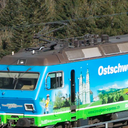

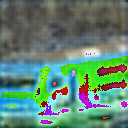

0.20136598820116983
0.2012999432511849
0.20128851475680404
0.20131978808956988
0.2012728438144777
0.20118148480225534
0.20113523700387007
0.20101386666871035
0.20113070252124202
0.20115661656572706
0.20130099419733924
0.20134248029229776
0.2013599566170867
0.20139455586393304
0.2012896295203719
0.20139082190063265
0.201380978256876
0.20129890199921546
0.20136826080546533
0.20145138027993115
0.2015262859034862
0.20148625667836215
0.2012785389150739
0.2016430803840714
0.20156896856096057
0.2014662108458249
0.2012299322215471
0.2012364052628216
0.20108866144996543
0.20095636041268058
0.2008880367784789
0.2010062101843028
0.201004663378384
0.20100308547162601
0.20092081820711177
0.2010679370013334
0.2010702475716796
0.2009771683511614
0.20093832922530475
0.2008619975298643
0.2008253805864896
0.2007625146715109
0.20082467359034614
0.20085951215663894
0.20072885344223101
0.2006747334953246
0.20070185316236397
0.20060526038850507
0.200463515448283
0.2005093042254448
epoch is done:  4


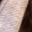

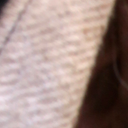

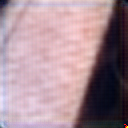

0.20050586688803487
0.20042349061086065
0.20016635094471127
0.19999487228750243
0.19989476116264568
0.19975852820789441
0.19972546966855165
0.19952273726925368
0.19946405648264645
0.1993380225621737
0.19937654176434338
0.19952540173557878
0.19938317071575629
0.19954796248313153
0.19929155808574747
0.19910825301605956
0.19898015768563704
0.19902669905281778
0.19911152711588212
0.1991411242220137
0.1991298848632517
0.1991929121534614
0.19924669257013788
0.19929776743163158
0.19936710048805584
0.19950037444199342
0.19946649987990245
0.1994680803563955
0.19953021604741347
0.19948865271040372
0.1993390372639449
0.1994025057829018
0.1993551428558127
0.1992456975432349
0.19920829482245864
0.1995337654452224
0.1995325784234635
0.19938943783442178
0.1993858972532114
0.19931449443101884
0.1991607346587984
0.1990628435901583
0.19901755447070346
0.1988374841760616
0.198777348560802
0.19854908542254487
0.1984153913227396
0.19845411986512626
0.19836636834519364
0.1983913844327132
epoch is done:  5


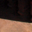

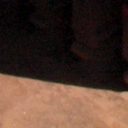

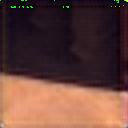

0.1983710129890727
0.19834125293603797
0.19826782069387217
0.19829681363741034
0.1983807104532836
0.19826110783550474
0.19818324816537602
0.19804266709592436
0.19797605666720752
0.19800211032552104
0.19795694698091487
0.19782466909442192
0.19765163972354927
0.19759967178106308
0.19741770525773367
0.19732968957175182
0.19718020533913694
0.197132963335739
0.1972821459501141
0.1972849172540009
0.1972451635238909
0.19725239711888828
0.19715324810045792
0.19723512637026516
0.19707992842564215
0.1971715151623714
0.19711371554511767
0.19706827492975607
0.19699913634717645
0.19690548605991132
0.19689211006250987
0.19672641817884273
0.19672758487967756
0.1966047008594353
0.1965383951343707
0.1966177144841779
0.19659435704836858
0.19654570233363372
0.196487964650171
0.19643390612567171
0.19636500060907908
0.19628574063031995
0.1962202130097342
0.1960971976608731
0.19583690414826074
0.195641437900721
0.19558930991791854
0.19555665229329433
0.19545927505011546
0.19549596103174346
epoch is done:  6

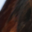

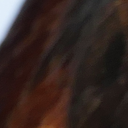

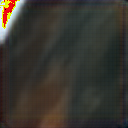

0.19544692000008038
0.19542160814374007
0.19529970874614147
0.19534198146334475
0.19527487824080694
0.19518624796542558
0.19530909642034552
0.19516772637403876
0.19515901092118207
0.19506109872212013
0.19502114062906964
0.19497805243121327
0.19498558619544526
0.195134504831263
0.1950591531314262
0.19496314197045858
0.19490303503151485
0.19484054947109974
0.19472866016755583
0.19465815402768755
0.19460522961825374
0.19454441521997734
0.19440798966798323
0.1943074586118925
0.19424746654431024
0.19420631957101694
0.1940812950543763
0.19404725854595503
0.19405033899407273
0.19396103708759735
0.19388529151834527
0.1939057622943561
0.1939000790214103
0.19388828153023496
0.1939219595356421
0.194018102468141
0.1939655213739521
0.19390898622265182
0.19398173255065412
0.19417652627214407
0.1941236319482479
0.19405240308949534
0.19406528886568758
0.1940008180433421
0.19394882044082956
0.1938657360433629
0.19383868926042874
0.1938469489128446
0.19380454564079605
0.19372646426782011
epoch is done: 

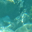

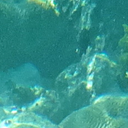

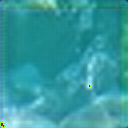

0.19368156119995283
0.19352854734555405
0.19341298839812243
0.1934125436156398
0.19352112730712068
0.19351329696662908
0.19342213504803563
0.19336892984003998
0.19328953312996838
0.19333713816069975
0.1932338169275119
0.19333163061115927
0.19339792093050104
0.1933257154904414
0.19320316226726555
0.19307077244425622
0.1930634883060444
0.19301245955117582
0.1931193198359667
0.19299816409392015
0.19295475302781742
0.192990203692591
0.1928955989561746
0.19296138134415983
0.19298212529981837
0.1929599681405674
0.19282763116323418
0.19279077776194176
0.19266969661959957
0.19258462511176286
0.1924773756319575
0.1925357735922767
0.1924904561311213
0.19250433124636177
0.19246783073263607
0.19247708683235382
0.19245981899019782
0.192392993990553
0.1924200025906867
0.19250833857804536
0.19248547878057237
0.1924042066736189
0.19236134502271499
0.1924055410163091
0.19233589683021052


KeyboardInterrupt: 

In [70]:
# Pretrain the generator
# Shentong suggests 50 epochs is good for this.

nepochs = 50
pretrain_loss = l1

# uncomment this if no optimizer initialized already.
# lr = 0.0005
# G_optimizer = optim.Adam(Generator.parameters(), lr=lr)

i = 0
total_loss = []
Generator.to(cuda)
Generator.train()
j = 0

for e in range(nepochs): # using the same i in the loop ?!
    Generator.train()
    for obj in train_loader:
        G_optimizer.zero_grad()
        i += 1
        lr, hr = obj
        lr = lr.to(cuda)
        hr = hr.to(cuda)

        y = Generator.forward(lr)
        loss = pretrain_loss(y, hr)
        loss.backward()
        G_optimizer.step()
        if i%500==0: # change this value since it changes a lot the training, it was set to 10,000, ie with bs = 16 and 800 images
            # in train_set, it requires 200 epochs to reach it, so decreases it to ~ 10 epochs -> 
            G_scheduler.step()
            print("learning rate updated for the ", j, " time")
        total_loss.append(loss.item())
        print(np.mean(total_loss))
        
    print("epoch is done: ", e)
    
    Generator.eval()
    x, y = full_train_data[np.random.randint(0, 800)]
    
    im0 = transforms.ToPILImage()(undo_transform(x)).convert("RGB")
    display(im0)
    y = undo_transform(y)
    im = transforms.ToPILImage()(y).convert("RGB")
    x = x.to(cuda)
    display(im)
    
    z = Generator(x.unsqueeze(0)).squeeze(0)
    display(transforms.ToPILImage()(z.cpu()).convert("RGB"))
    
#     z2 = undo_transform(z)

#     display(transforms.ToPILImage()(z2.cpu()).convert("RGB"))
#     display(transforms.ToPILImage()(undo_transform(z).cpu()).convert("RGB"))

    
# reloading the checkpoint saved Generator's state_dict and reloading the optimizer works for continous training here.

# be careful: I think I understood the issue with undo_transform -> when applied it seems to affect even other
# images before, so don't use it for the output !

In [21]:
def save_checkpoint(state, is_best, filename=content_path+'Generator_trained2.tar'):
    torch.save(state, filename)
#     if is_best:
#         shutil.copyfile(filename, 'model_best.pth.tar')

In [98]:
# # save the model with state dict
# save_checkpoint({
#             'epoch': nepochs,
#             'state_dict': Generator.state_dict(),
#             'optimizer' : G_optimizer.state_dict(),
#         }, is_best=True, filename=content_path+'Generator_trained3.tar')

In [22]:
# learning rate for GAN training
lr = 0.00005
G_optimizer.lr = lr

In [97]:
# G_optimizer = optim.Adam(Generator.parameters(), lr=lr)
# D_optimizer = optim.Adam(Discriminator.parameters(), lr=lr)

In [23]:
# recover the Generator saved
checkpoint = torch.load(content_path+'Generator_SRGAN.tar')

# start_epoch = checkpoint['epoch']
Generator.load_state_dict(checkpoint['state_dict'])
G_optimizer.load_state_dict(checkpoint['optimizer'])

for state in G_optimizer.state.values():
    for k, v in state.items():
        if torch.is_tensor(v):
            state[k] = v.cuda()

In [24]:
# recover the Discriminator saved
checkpoint = torch.load(content_path+'Discriminator_SRGAN.tar')

# start_epoch = checkpoint['epoch']
Discriminator.load_state_dict(checkpoint['state_dict'])
D_optimizer.load_state_dict(checkpoint['optimizer'])

for state in D_optimizer.state.values():
    for k, v in state.items():
        if torch.is_tensor(v):
            state[k] = v.cuda()

In [102]:
# # # consider using the scheduler when applying PSNR validation metric

# G_scheduler = torch.optim.lr_scheduler.StepLR(G_optimizer, gamma=0.5, step_size=1)
# D_scheduler = torch.optim.lr_scheduler.StepLR(D_optimizer, gamma=0.8, step_size=5)

In [ ]:
########### TRY TO TRAIN STARTING WITH THE OTHER LOSS FUNCTION for start 

discriminator L1 loss for prediction:  0.3539441352477297
discriminator L1 loss for prediction:  0.31968577206134796
discriminator L1 loss for prediction:  0.1202317625284195
discriminator L1 loss for prediction:  0.2719416171312332
discriminator L1 loss for prediction:  0.18290045857429504


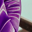

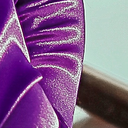

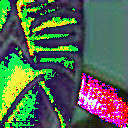

epoch done:  1  and discriminator & generator training losses for this epoch:
[10.0591, 3.4357, 2.3988, 1.4869, 0.9842, 0.806, 0.9515, 1.2966, 0.9309, 0.6466, 0.8989, 0.9106, 0.6197, 0.6525, 0.576, 0.5558, 1.265, 0.3207, 0.3293, 0.8779, 0.5274, 0.4306, 0.6455, 0.6264, 0.8585, 1.0936, 0.5523, 0.6032, 0.5949, 0.6719, 0.6746, 0.7669, 0.6524, 0.8567, 0.4765, 0.7498, 0.6138, 1.0506, 0.5817, 0.5739, 0.9954, 0.4834, 0.7781, 0.7229, 0.828, 0.9201, 0.6371, 0.4686, 0.4433, 0.4387]
[0.1105, 0.1174, 0.0813, 0.1384, 0.0965, 0.1122, 0.0912, 0.0755, 0.1027, 0.1184, 0.0941, 0.1269, 0.1102, 0.0996, 0.1084, 0.1254, 0.0682, 0.0978, 0.1115, 0.0843, 0.1214, 0.1458, 0.0952, 0.0889, 0.099, 0.1047, 0.0799, 0.102, 0.1232, 0.1036, 0.1049, 0.1052, 0.1242, 0.1052, 0.1054, 0.1028, 0.1076, 0.098, 0.1353, 0.0982, 0.1164, 0.0838, 0.1028, 0.1134, 0.1295, 0.0683, 0.1053, 0.0879, 0.1292, 0.1339]
discriminator L1 loss for prediction:  0.15618881583213806
discriminator L1 loss for prediction:  0.08260452747344971
discrimi

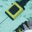

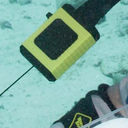

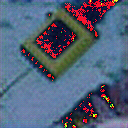

epoch done:  2  and discriminator & generator training losses for this epoch:
[0.4704, 0.5705, 0.5493, 0.8084, 0.7249, 0.3986, 0.5424, 0.2896, 0.1769, 0.2986, 0.2809, 0.1952, 0.2703, 0.2325, 0.3445, 0.521, 0.2391, 0.0597, 0.0726, 0.4583, 0.0253, 0.037, 0.2504, 0.0933, 0.6962, 0.4069, 1.0325, 1.1312, 0.6856, 0.5841, 0.5572, 0.1783, 1.2779, 0.5254, 0.5148, 0.2794, 0.2192, 0.5615, 0.585, 0.447, 0.8392, 0.4751, 0.6472, 0.7291, 0.5378, 0.5125, 0.7105, 0.4428, 0.6848, 0.3645]
[0.1113, 0.1237, 0.1023, 0.0996, 0.073, 0.1257, 0.1112, 0.085, 0.0991, 0.1001, 0.1354, 0.1073, 0.1021, 0.1023, 0.0947, 0.1386, 0.0767, 0.0826, 0.1041, 0.1005, 0.1083, 0.0896, 0.1024, 0.1175, 0.101, 0.1334, 0.0846, 0.0805, 0.111, 0.1063, 0.0994, 0.0952, 0.1264, 0.0803, 0.116, 0.1367, 0.1276, 0.0763, 0.128, 0.1158, 0.1086, 0.1262, 0.0999, 0.1052, 0.1038, 0.1074, 0.0936, 0.0911, 0.1036, 0.1178]
discriminator L1 loss for prediction:  0.18400993943214417
discriminator L1 loss for prediction:  0.09541906043887138
discriminato

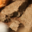

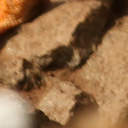

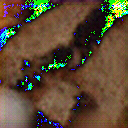

epoch done:  3  and discriminator & generator training losses for this epoch:
[0.5654, 0.6498, 0.5172, 0.3667, 0.3288, 0.3977, 0.3247, 0.336, 0.6915, 0.5222, 0.2316, 0.2465, 0.3707, 0.295, 0.1985, 0.3728, 0.1641, 0.3586, 0.393, 0.3131, 0.0976, 0.2819, 0.3931, 0.2299, 0.1741, 0.1938, 0.2535, 0.3686, 0.3566, 0.2392, 0.2642, 0.212, 0.2917, 0.2852, 0.2866, 0.4607, 0.2099, 0.5473, 0.4073, 0.3474, 0.1547, 0.2318, 0.0396, 0.2274, 0.1606, 0.2146, 0.4438, 0.1646, 0.3282, 0.0125]
[0.1043, 0.1142, 0.1051, 0.1078, 0.1093, 0.0987, 0.0957, 0.1066, 0.0898, 0.093, 0.1095, 0.1175, 0.1039, 0.1054, 0.095, 0.0899, 0.0773, 0.1088, 0.1155, 0.1005, 0.1128, 0.1237, 0.1104, 0.1043, 0.1127, 0.1558, 0.0904, 0.1049, 0.1142, 0.1087, 0.1029, 0.1288, 0.1097, 0.1177, 0.1093, 0.1015, 0.1225, 0.0856, 0.1721, 0.0988, 0.1225, 0.0829, 0.1296, 0.1062, 0.104, 0.0878, 0.096, 0.0993, 0.134, 0.1317]
discriminator L1 loss for prediction:  0.04028479638509452
discriminator L1 loss for prediction:  0.14728492870926857
discriminat

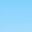

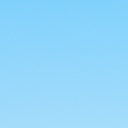

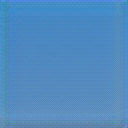

epoch done:  4  and discriminator & generator training losses for this epoch:
[0.0395, 0.1967, 0.0868, 0.4147, 0.2837, 0.2337, 0.4164, 0.0976, 0.5984, 1.1076, 0.2862, 0.6326, 0.5242, 0.1543, 0.4536, 0.8707, 0.4667, 0.1518, 0.207, 0.4659, 0.3044, 0.384, 0.4632, 0.1617, 0.178, 0.184, 0.5492, 0.3624, 0.2565, 0.3042, 0.3827, 0.2568, 0.504, 0.3379, 0.1963, 0.09, 0.0562, 0.9468, 0.6388, 0.2042, 0.1347, 0.1428, 0.5928, 0.7055, 0.1492, 0.3018, 0.1949, 0.2946, 0.1671, 0.2963]
[0.0877, 0.0974, 0.0888, 0.1106, 0.0969, 0.1238, 0.1287, 0.097, 0.1146, 0.0896, 0.1214, 0.1117, 0.0971, 0.0942, 0.0879, 0.0986, 0.1171, 0.0819, 0.0858, 0.1073, 0.1131, 0.103, 0.0934, 0.0986, 0.1203, 0.1297, 0.0865, 0.1085, 0.108, 0.1159, 0.0865, 0.1241, 0.1298, 0.109, 0.0935, 0.1375, 0.0938, 0.1146, 0.0938, 0.1051, 0.1033, 0.1174, 0.0945, 0.1039, 0.1164, 0.092, 0.1187, 0.1089, 0.1137, 0.1324]
discriminator L1 loss for prediction:  0.05538151692599058
discriminator L1 loss for prediction:  0.021245116367936134
discriminator

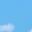

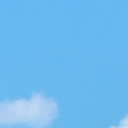

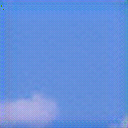

epoch done:  5  and discriminator & generator training losses for this epoch:
[0.0914, 0.2448, 0.2081, 0.1795, 0.1292, 0.1763, 0.2524, 0.1104, 0.057, 0.3787, 0.2367, 0.0449, 0.1228, 0.1194, 0.1482, 0.3705, 0.0934, 0.0672, 0.2138, 0.039, 0.0725, 0.1428, 0.0278, 0.0509, 0.3805, 0.1696, 0.2096, 0.0892, 0.0618, 0.1722, 0.087, 0.0467, 0.0608, 0.0893, 0.0195, 0.021, 0.0228, 0.054, 0.0289, 0.1193, 0.1397, 0.1358, 0.1109, 0.1147, 0.1237, 0.0815, 0.0412, 0.3626, 0.029, 0.1133]
[0.1006, 0.1138, 0.0894, 0.0998, 0.1077, 0.0957, 0.0815, 0.0904, 0.1218, 0.1017, 0.1164, 0.1305, 0.0924, 0.0844, 0.0823, 0.083, 0.0995, 0.1222, 0.0891, 0.128, 0.095, 0.0849, 0.1287, 0.1151, 0.0808, 0.0931, 0.0837, 0.1051, 0.1209, 0.1069, 0.1192, 0.1219, 0.103, 0.107, 0.1075, 0.107, 0.1006, 0.1211, 0.1319, 0.1036, 0.1261, 0.0937, 0.1149, 0.1068, 0.1278, 0.1078, 0.0869, 0.1293, 0.1296, 0.0948]
discriminator L1 loss for prediction:  0.05829622782766819
discriminator L1 loss for prediction:  0.021489042788743973
discriminator

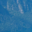

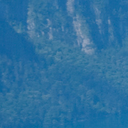

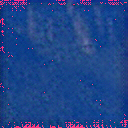

epoch done:  6  and discriminator & generator training losses for this epoch:
[0.069, 0.1698, 0.0622, 0.3511, 0.0555, 0.0423, 0.0186, 0.5572, 0.0257, 0.3023, 0.1997, 0.0541, 0.1109, 0.0184, 0.2388, 0.0881, 0.0995, 0.0316, 0.0441, 0.0449, 0.0046, 0.0154, 0.1941, 0.0758, 0.0163, 0.2541, 0.0069, 0.1139, 0.0603, 0.2247, 0.0255, 0.1058, 0.0589, 0.1662, 0.0292, 0.0543, 0.0039, 0.0521, 0.0245, 0.1579, 0.0224, 0.0591, 0.0301, 0.0499, 0.0466, 0.0296, 0.0744, 0.0241, 0.0316, 0.0517]
[0.1062, 0.0932, 0.1186, 0.1085, 0.1065, 0.1162, 0.1459, 0.0809, 0.1244, 0.0897, 0.0848, 0.0966, 0.0731, 0.0894, 0.0569, 0.0891, 0.0678, 0.1083, 0.0881, 0.1127, 0.1348, 0.1165, 0.1113, 0.1402, 0.0855, 0.1112, 0.0868, 0.0939, 0.0873, 0.111, 0.0911, 0.0967, 0.1377, 0.0791, 0.0844, 0.1108, 0.1132, 0.1259, 0.0942, 0.112, 0.1338, 0.0938, 0.1176, 0.094, 0.1102, 0.095, 0.0943, 0.1006, 0.1351, 0.0871]
discriminator L1 loss for prediction:  0.02919927053153515
discriminator L1 loss for prediction:  0.030001670122146606
discri

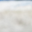

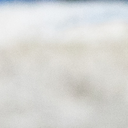

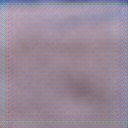

epoch done:  7  and discriminator & generator training losses for this epoch:
[0.0045, 0.0629, 0.0408, 0.0648, 0.0739, 0.0326, 0.1974, 0.0522, 0.0026, 0.0684, 0.0173, 0.1028, 0.0335, 0.0168, 0.059, 0.0245, 0.0236, 0.0178, 0.0588, 0.0014, 0.0039, 0.0019, 0.0127, 0.0603, 0.0095, 0.0132, 0.0425, 0.0098, 0.007, 0.0056, 0.0088, 0.0025, 0.04, 0.0047, 0.0016, 0.0057, 0.0027, 0.0052, 0.062, 0.0019, 0.0031, 0.0316, 0.002, 0.0211, 0.0029, 0.0021, 0.089, 0.0299, 0.0013, 0.0168]
[0.119, 0.1057, 0.1249, 0.1312, 0.1066, 0.1164, 0.0904, 0.0991, 0.1164, 0.1083, 0.1192, 0.1164, 0.1027, 0.1078, 0.0904, 0.1172, 0.0974, 0.087, 0.0941, 0.1228, 0.1158, 0.1087, 0.1119, 0.0993, 0.0892, 0.1067, 0.0862, 0.114, 0.1062, 0.095, 0.1244, 0.1071, 0.0926, 0.1288, 0.1076, 0.1424, 0.0949, 0.1237, 0.1378, 0.1029, 0.1115, 0.0751, 0.0977, 0.1107, 0.1063, 0.1032, 0.0854, 0.1296, 0.1366, 0.1025]
discriminator L1 loss for prediction:  0.0026173735968768597
discriminator L1 loss for prediction:  8.64955218276009e-05
discrimina

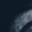

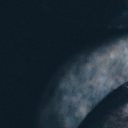

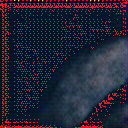

epoch done:  8  and discriminator & generator training losses for this epoch:
[0.0202, 0.0053, 0.0141, 0.0249, 0.0012, 0.0016, 0.0003, 0.0, 0.0044, 0.1508, 0.2682, 0.0002, 0.3316, 0.0226, 0.2693, 0.0056, 0.0292, 0.166, 0.1426, 0.2117, 0.3072, 0.0545, 0.1262, 0.1207, 0.1163, 0.2865, 0.0052, 0.1537, 0.0126, 0.5355, 0.1152, 0.0009, 0.001, 0.0407, 0.0446, 0.0091, 0.0035, 0.0475, 0.4123, 0.0182, 0.1687, 0.0458, 0.1031, 0.0171, 0.0422, 0.0487, 0.0613, 0.0253, 0.018, 0.0433]
[0.1107, 0.1188, 0.1112, 0.1148, 0.1082, 0.109, 0.0807, 0.0836, 0.0984, 0.0966, 0.0835, 0.1337, 0.079, 0.0966, 0.0855, 0.1206, 0.1042, 0.1169, 0.0863, 0.0898, 0.1153, 0.108, 0.0923, 0.09, 0.0924, 0.0926, 0.0681, 0.1013, 0.1306, 0.1132, 0.104, 0.1179, 0.1525, 0.0921, 0.1047, 0.1536, 0.1241, 0.115, 0.1106, 0.0967, 0.1155, 0.0959, 0.1058, 0.1234, 0.1089, 0.0851, 0.0983, 0.0966, 0.1407, 0.1196]
discriminator L1 loss for prediction:  0.0112214470282197
discriminator L1 loss for prediction:  0.002247897136840038
discriminator L

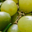

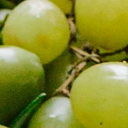

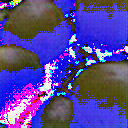

epoch done:  9  and discriminator & generator training losses for this epoch:
[0.0184, 0.0238, 0.0534, 0.0148, 0.0377, 0.0435, 0.015, 0.0071, 0.025, 0.0036, 0.0155, 0.0046, 0.0006, 0.0424, 0.0048, 0.0226, 0.0585, 0.0023, 0.0125, 0.1272, 0.0079, 0.0115, 0.0091, 0.0207, 0.0025, 0.0045, 0.0078, 0.0302, 0.0123, 0.4787, 0.0562, 0.0046, 0.0056, 0.0075, 0.2656, 0.0032, 0.0019, 0.0043, 0.0111, 0.0018, 0.1341, 0.0006, 0.0476, 0.0078, 0.1464, 0.1842, 0.083, 0.1425, 0.2614, 0.0291]
[0.1064, 0.1285, 0.1061, 0.1181, 0.1107, 0.1267, 0.1008, 0.1054, 0.0728, 0.1007, 0.1159, 0.1013, 0.1039, 0.088, 0.1125, 0.092, 0.0824, 0.1029, 0.102, 0.1055, 0.1116, 0.1158, 0.0832, 0.1074, 0.1153, 0.1081, 0.1059, 0.101, 0.0909, 0.1167, 0.1034, 0.1091, 0.1388, 0.0816, 0.0806, 0.1402, 0.0985, 0.1159, 0.1255, 0.1216, 0.1412, 0.1036, 0.1115, 0.0936, 0.0957, 0.0879, 0.0752, 0.0869, 0.0942, 0.1106]
discriminator L1 loss for prediction:  0.02898554690182209
discriminator L1 loss for prediction:  0.003247553016990423
discrimi

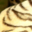

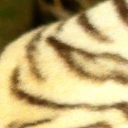

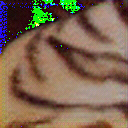

epoch done:  10  and discriminator & generator training losses for this epoch:
[0.0356, 0.0893, 0.2489, 0.0379, 0.1353, 0.0598, 0.026, 0.0158, 0.0044, 0.0386, 0.0117, 0.0066, 0.0028, 0.0115, 0.0265, 0.024, 0.0247, 0.0134, 0.1455, 0.1314, 0.0055, 0.2444, 0.0108, 0.0081, 0.0429, 0.048, 0.0359, 0.0273, 0.0387, 0.0047, 0.0054, 0.0008, 0.0265, 0.0018, 0.0013, 0.0045, 0.0207, 0.1176, 0.0208, 0.0047, 0.0005, 0.0112, 0.0075, 0.0087, 0.0921, 0.0031, 0.0203, 0.2069, 0.0092, 0.0001]
[0.1155, 0.1396, 0.1077, 0.1012, 0.0814, 0.1085, 0.0927, 0.1, 0.1057, 0.0797, 0.1121, 0.1307, 0.112, 0.0842, 0.0707, 0.1099, 0.1038, 0.0975, 0.1012, 0.0825, 0.1096, 0.098, 0.0922, 0.1099, 0.1003, 0.1188, 0.0733, 0.0742, 0.1236, 0.1271, 0.0832, 0.1216, 0.1291, 0.1098, 0.1024, 0.1195, 0.1046, 0.1078, 0.1015, 0.1322, 0.1101, 0.1013, 0.1074, 0.0803, 0.07, 0.0633, 0.0905, 0.086, 0.1137, 0.1364]
discriminator L1 loss for prediction:  0.027092787975561805
discriminator L1 loss for prediction:  0.0001252287911484018
discrimin

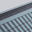

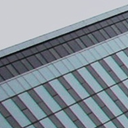

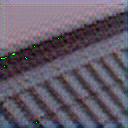

epoch done:  11  and discriminator & generator training losses for this epoch:
[0.003, 0.1017, 0.014, 0.0172, 0.0011, 0.0024, 0.0028, 0.0196, 0.0003, 0.0781, 0.0014, 0.0003, 0.0007, 0.0019, 0.043, 0.0335, 0.0187, 0.0103, 0.0017, 0.0026, 0.0117, 0.0005, 0.025, 0.0019, 0.0017, 0.0501, 0.0175, 0.0005, 0.0003, 0.0054, 0.0884, 0.0013, 0.0077, 0.0228, 0.0001, 0.0004, 0.0025, 0.0063, 0.0063, 0.0028, 0.0002, 0.0001, 0.0003, 0.0027, 0.0209, 0.0002, 0.0005, 0.0004, 0.0001, 0.0019]
[0.1061, 0.0968, 0.1412, 0.0944, 0.1002, 0.1123, 0.0979, 0.1113, 0.1222, 0.0996, 0.1206, 0.1181, 0.1347, 0.0974, 0.0895, 0.125, 0.0774, 0.0786, 0.0875, 0.0941, 0.1043, 0.1354, 0.0991, 0.0993, 0.0997, 0.0994, 0.1004, 0.127, 0.0972, 0.1136, 0.0962, 0.1001, 0.1003, 0.0899, 0.0677, 0.0978, 0.1029, 0.1058, 0.1249, 0.1042, 0.1238, 0.1093, 0.1248, 0.0977, 0.0878, 0.116, 0.1005, 0.1232, 0.1674, 0.0775]
discriminator L1 loss for prediction:  0.003199918137397617
discriminator L1 loss for prediction:  4.041974989377195e-06
discr

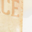

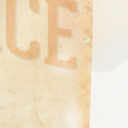

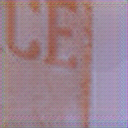

epoch done:  12  and discriminator & generator training losses for this epoch:
[0.0004, 0.0067, 0.003, 0.0009, 0.0002, 0.0014, 0.0476, 0.0021, 0.0008, 0.0002, 0.0004, 0.0, 0.0002, 0.0029, 0.013, 0.0291, 0.0039, 0.01, 0.0044, 0.0011, 0.0041, 0.0012, 0.004, 0.0006, 0.0147, 0.0169, 0.0027, 0.0001, 0.0005, 0.0584, 0.0004, 0.0471, 0.0002, 0.0003, 0.0003, 0.0001, 0.0149, 0.0072, 0.0105, 0.0002, 0.0005, 0.0002, 0.0013, 0.0019, 0.0002, 0.0065, 0.0061, 0.0003, 0.0035, 0.0001]
[0.0909, 0.1186, 0.1084, 0.096, 0.108, 0.0936, 0.1325, 0.0954, 0.104, 0.1284, 0.115, 0.1612, 0.0986, 0.1048, 0.0807, 0.0743, 0.0925, 0.1025, 0.0899, 0.1038, 0.1021, 0.1057, 0.1134, 0.0862, 0.097, 0.11, 0.1244, 0.0954, 0.0795, 0.0924, 0.0926, 0.1044, 0.1284, 0.0745, 0.0852, 0.1138, 0.1005, 0.1281, 0.1017, 0.0788, 0.1278, 0.1323, 0.0955, 0.0809, 0.0895, 0.1127, 0.0871, 0.1072, 0.136, 0.1201]
discriminator L1 loss for prediction:  0.00019539130153134465
discriminator L1 loss for prediction:  0.0005753459272455075
discriminato

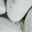

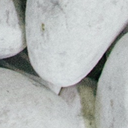

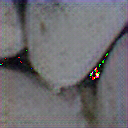

epoch done:  13  and discriminator & generator training losses for this epoch:
[0.0342, 0.0004, 0.0001, 0.0001, 0.0002, 0.0152, 0.0001, 0.0, 0.001, 0.0041, 0.0005, 0.0012, 0.0129, 0.0019, 0.015, 0.0852, 0.0004, 0.0001, 0.0007, 0.0525, 0.001, 0.1983, 0.0108, 0.001, 0.0004, 0.0047, 0.1547, 0.0567, 0.0, 0.1318, 0.0027, 0.0001, 0.0035, 0.0845, 0.0434, 0.0062, 0.004, 0.1229, 0.0114, 0.0023, 0.0011, 0.0436, 0.0561, 0.1097, 0.0001, 0.0031, 0.0119, 0.169, 0.0004, 0.0035]
[0.089, 0.1154, 0.1105, 0.1037, 0.1244, 0.096, 0.0852, 0.111, 0.1296, 0.0958, 0.1197, 0.1027, 0.1131, 0.0959, 0.0746, 0.1421, 0.1121, 0.1132, 0.1176, 0.1099, 0.1144, 0.0984, 0.0995, 0.0902, 0.1262, 0.1182, 0.0945, 0.1016, 0.1204, 0.093, 0.0874, 0.1153, 0.1189, 0.1336, 0.0824, 0.1251, 0.1159, 0.0843, 0.1099, 0.074, 0.1177, 0.1014, 0.0792, 0.0998, 0.1026, 0.1087, 0.0865, 0.1319, 0.1308, 0.0951]
discriminator L1 loss for prediction:  0.0005520415870705619
discriminator L1 loss for prediction:  8.874454942997545e-05
discriminator 

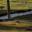

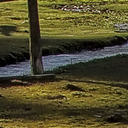

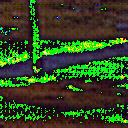

epoch done:  14  and discriminator & generator training losses for this epoch:
[0.0019, 0.0011, 0.0009, 0.0009, 0.0034, 0.0012, 0.0005, 0.0061, 0.0021, 0.0002, 0.0014, 0.0002, 0.0963, 0.0006, 0.0004, 0.0039, 0.0018, 0.0014, 0.0042, 0.0023, 0.0001, 0.0015, 0.0502, 0.0004, 0.003, 0.0018, 0.0006, 0.0002, 0.0008, 0.0004, 0.0002, 0.0012, 0.0013, 0.0007, 0.0008, 0.0015, 0.0001, 0.0059, 0.0111, 0.0002, 0.0077, 0.0004, 0.0007, 0.0005, 0.0002, 0.0003, 0.0027, 0.0003, 0.0016, 0.0003]
[0.0737, 0.1031, 0.1106, 0.1073, 0.0873, 0.1226, 0.1408, 0.0614, 0.1359, 0.1027, 0.1193, 0.1368, 0.1062, 0.0932, 0.0995, 0.1057, 0.0718, 0.1008, 0.1152, 0.1176, 0.1168, 0.0771, 0.1065, 0.1183, 0.1014, 0.1346, 0.0846, 0.1037, 0.1101, 0.1154, 0.1136, 0.116, 0.1099, 0.0933, 0.0911, 0.1011, 0.0927, 0.0921, 0.1011, 0.1123, 0.1304, 0.1087, 0.1001, 0.092, 0.1014, 0.0804, 0.0869, 0.1032, 0.1522, 0.0743]
discriminator L1 loss for prediction:  0.001085459972728131
discriminator L1 loss for prediction:  3.630529681686312e-05
d

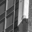

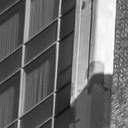

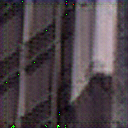

epoch done:  15  and discriminator & generator training losses for this epoch:
[0.0, 0.0022, 0.0002, 0.0001, 0.0052, 0.0004, 0.0, 0.0001, 0.0, 0.0007, 0.0217, 0.0001, 0.0004, 0.0001, 0.0, 0.0001, 0.0002, 0.0, 0.0002, 0.0022, 0.0001, 0.0016, 0.0001, 0.0001, 0.0001, 0.0001, 0.0029, 0.0001, 0.0001, 0.0005, 0.0003, 0.0, 0.0001, 0.0002, 0.0001, 0.0002, 0.0003, 0.0001, 0.0016, 0.0002, 0.0005, 0.0004, 0.0003, 0.0013, 0.0001, 0.0003, 0.0002, 0.0006, 0.0, 0.0004]
[0.1262, 0.122, 0.1149, 0.1067, 0.1049, 0.1086, 0.1092, 0.1203, 0.1043, 0.0857, 0.0748, 0.126, 0.1021, 0.0902, 0.1131, 0.079, 0.0773, 0.0865, 0.1007, 0.091, 0.1297, 0.1209, 0.0845, 0.089, 0.1258, 0.1042, 0.0793, 0.1336, 0.1067, 0.1168, 0.1208, 0.1057, 0.1223, 0.1105, 0.1357, 0.1122, 0.1304, 0.1399, 0.0989, 0.1231, 0.1361, 0.1156, 0.1086, 0.0934, 0.0961, 0.0937, 0.0817, 0.0954, 0.1281, 0.1396]
discriminator L1 loss for prediction:  0.00015173803694779053
discriminator L1 loss for prediction:  4.804510354006197e-06


KeyboardInterrupt: 

In [25]:
nepochs = 150

# trying learning rate lr = 0.0001 (in paper: somewhere between 10-4 and 10-5)

# Shentong's comments:


# Early stopping may be important
# Idea: add PSNR metric for testing.
# Implement PSNR metric; print out the value and check it every so often

gen_l, disc_l = [], []
for i in range(nepochs):
    disc_losses = []
    gen_losses = []
    
    # in the paper they alternate training the discriminator and the generator (k=1, see paper 3.2)
    
    # strange, here the discriminator is fully trained on all batches and then generator also
    # but they should be trained successively on batches I assume
    
    
    # Train the discriminator
    for k, obj in enumerate(train_loader):
        lr, hr = obj
        Generator.to(cuda)
        Generator.eval()
        with torch.no_grad():
            lr = lr.to(cuda)
            z = Generator.forward(lr)
        z = z.to(cuda)
        Discriminator.to(cuda)
        
        # the train function uses the optimizer defined above: D_optimizer (global variable)
        loss, avg_l1 = discriminator_train(hr, z, disc_loss) #disc loss is a bad name -- this is the discriminator loss
        
        if k%10==1:
            print("discriminator L1 loss for prediction: ", avg_l1)
            
        torch.cuda.empty_cache()
        disc_losses.append(round(loss, 4))

    # Train the generator
#     for obj in train_loader: 

        Discriminator.eval()
        lr, hr = obj
        # the train function uses the optimizer defined above: G_optimizer (global variable)
        loss = generator_train(lr, hr, gen_loss)
        torch.cuda.empty_cache()
        gen_losses.append(round(loss, 4))

        
    # tried to open x, y = full_train_data[0] but need to undo the normalization to visualize it properly
    x, y = full_train_data[np.random.randint(0, 800)]
    display(transforms.ToPILImage()(undo_transform(x)).convert("RGB"))
    display(transforms.ToPILImage()(undo_transform(y)).convert("RGB"))
    x = x.to(cuda)
    z = Generator(x.unsqueeze(0)).squeeze(0)
    display(transforms.ToPILImage()(z.cpu()).convert("RGB"))
    
    print("epoch done: ", i+1, " and discriminator & generator training losses for this epoch:")
    print(disc_losses)
    print(gen_losses)

In [ ]:
# try to print the average of the distance to the real classes for discriminator to see if it learns or not and 
# if it does well since the start

In [26]:
save_checkpoint({
            'epoch': nepochs,
            'state_dict': Generator.state_dict(),
            'optimizer' : G_optimizer.state_dict(),
        }, is_best=True, filename=content_path+'Generator_SRGAN2.tar')

In [27]:
save_checkpoint({
            'epoch': nepochs,
            'state_dict': Discriminator.state_dict(),
            'optimizer' : D_optimizer.state_dict(),
        }, is_best=True, filename=content_path+'Discriminator_SRGAN2.tar')

In [ ]:
# comments here:

# issues with training images ? when try to print them they appear strangely as opposed to 
# when printed in the Generator training only (?!)

# solved (sould be) here: https://discuss.pytorch.org/t/understanding-transform-normalize/21730/18
# strange output is just that the train images are normalized btw 0,1 and matplotlib tries to rescale it to print.

# but doesn't explain why during the first generator only, the images are showed well




##### for validation images, consider adding the normalization also for validation purposes?
##### and undoing the normalization after passing into the generator? does this work?

Some testing cells below:

In [ ]:
# implement PSNR metric


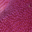

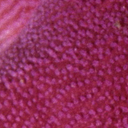

In [80]:
x, y = full_train_data[0]
display(transforms.ToPILImage()(undo_transform(x)).convert("RGB"))
display(transforms.ToPILImage()(undo_transform(y)).convert("RGB"))

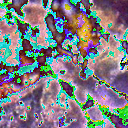

In [73]:
from torchvision import transforms
x, y = full_train_data[0]
im = transforms.ToPILImage()(y).convert("RGB")
display(im)

In [ ]:
x = x.to(cuda)
Generator.to(cuda)
z = Generator(x.unsqueeze(0)).squeeze(0)
im2 = transforms.ToPILImage()(z).convert("RGB")
display(im2)

In [ ]:
x, y = full_valid_data[0]
im = transforms.ToPILImage()(y).convert("RGB")
x = x.to(cuda)
display(im)
z = Generator(x.unsqueeze(0)).squeeze(0)
z = z.to(cuda)
im2 = transforms.ToPILImage()(z).convert("RGB")
display(im2)

